
# 3.5 Ridge regression

Se refiere al modelo de regresión lineal con penalización sobre la magnitud de los coeficientes

$$\min_{\boldsymbol{\omega}}|| \mathbf{y} - \mathbf{X}\boldsymbol{\omega}||_2^2 + \alpha ||\boldsymbol{\omega} ||_2^2$$

como medida contra el [*overfitting*](https://en.wikipedia.org/wiki/Overfitting)

El modelo de [*ridge regression*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), tiene un parámetro libre ($\alpha$) que hemos de fijar a priori. En otras palabras, tenemos que dar un valor a $\alpha$ para que el modelo calcule los coeficientes $\boldsymbol{\omega}$. A tener en cuenta:

* Si $\alpha = 0$, entonces el resultado coincide con un modelo de [regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
* Si $\alpha \to \infty$, entonces el valor de todos los coeficientes será nulo.

Por tanto, para buscar el valor de $\alpha$ adecuado, tendremos que barrer valores en una escala que cubra valores muy pequeños y valores elevados. Para ello, normalmente se utiliza escala logarítmica aumentando progresivamente el orden  de magnitud. Como ejemplo, podríamos barrer lambda utilizando los siguientes valores $\alpha = \{10^{-3},0.01,0.1,1,10,100,1000\}$, que en escala logarítmica queda como $\log_{10}({\alpha}) = \{-3,-2,-1,0,1,2,3\}$

Vamos a implementar el algoritmo de *ridge regression* variando los valores de $\alpha$, y viendo cómo esta variación afecta a los coeficientes $\boldsymbol{\omega}$ del modelo. Posteriormente, utilizaremos una estrategia de [*k-fold cross-validation*](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) para calcular el valor de $\alpha$ óptimo 

Como en casos anteriores, utilizaremos la base de datos de viviendas [House Sales in King COunty, USA](https://www.kaggle.com/harlfoxem/housesalesprediction).

In [3]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from math import log

## Cargar datos

In [4]:
# cargamos fichero
house_data = pd.read_csv("../data/house_data.csv") 

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = 2018 - house_data['yr_built']
house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: log(x))
house_data['lat_plus_long']    = house_data['lat']*house_data['long']
house_data =house_data.dropna()

In [5]:
house_data.head(5)

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,...,98178,47.5112,-122.257,124.490074,524.902176,63,9,3.00,4.697071,-5808.576778
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,...,98125,47.7210,-122.319,157.006138,709.686323,67,9,6.75,5.475462,-5837.184999
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,...,98028,47.7379,-122.233,252.696269,748.984308,85,4,2.00,4.270192,-5835.146731
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,...,98136,47.5208,-122.393,126.348134,464.515200,53,16,12.00,5.204501,-5816.213274
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,...,98074,47.6168,-122.045,167.225472,697.051509,31,9,6.00,5.050350,-5811.392356


## 3.5.1 Probando valores de $\alpha$

Dividamos los datos en un conjunto de entrenamiento y test, y escalémoslos convenientemente.

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.as_matrix() 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2, random_state = 2)

print ('Datos entrenamiento: ', Xtrain.shape)
print ('Datos test: ', Xtest.shape)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(Xtrain)
XtrainScaled = scaler.transform(Xtrain)
XtestScaled = scaler.transform(Xtest)

Datos entrenamiento:  (2531, 23)
Datos test:  (633, 23)


Entrenemos distintos modelos con distintos valores de $\alpha$ y veamos cuál se comporta mejor

In [21]:
from sklearn.linear_model import Ridge

alphaVector = [0.0001,0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000, 10000]
# este vector puede definirse en escala logarítmica como:
alphaVector = np.logspace(-10,10,21)
print(alphaVector)
mseVector = np.zeros(alphaVector.shape)

for i in range(0,len(alphaVector)):
    
    alphaValue = alphaVector[i]
    ridgeModel = Ridge(alpha = alphaValue)
    ridgeModel.fit(X,y)
    w = ridgeModel.coef_[0]
    norm_w2 = np.dot(w,w.T)
    
    print ('Ajustado modelo con alpha = %0.2g ...' % alphaValue, '\t con ||w||_2^2 = %0.3g' % norm_w2)
    
    ypred = ridgeModel.predict(XtestScaled)
    mseVector[i] = mean_squared_error(ytest,ypred)

[1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09
 1.e+10]
Ajustado modelo con alpha = 1e-10 ... 	 con ||w||_2^2 = 2.41e+16
Ajustado modelo con alpha = 1e-09 ... 	 con ||w||_2^2 = 2.41e+16
Ajustado modelo con alpha = 1e-08 ... 	 con ||w||_2^2 = 2.41e+16
Ajustado modelo con alpha = 1e-07 ... 	 con ||w||_2^2 = 2.4e+16
Ajustado modelo con alpha = 1e-06 ... 	 con ||w||_2^2 = 2.33e+16
Ajustado modelo con alpha = 1e-05 ... 	 con ||w||_2^2 = 1.74e+16
Ajustado modelo con alpha = 0.0001 ... 	 con ||w||_2^2 = 3.16e+15
Ajustado modelo con alpha = 0.001 ... 	 con ||w||_2^2 = 7.05e+13
Ajustado modelo con alpha = 0.01 ... 	 con ||w||_2^2 = 1.63e+12
Ajustado modelo con alpha = 0.1 ... 	 con ||w||_2^2 = 8.6e+11
Ajustado modelo con alpha = 1 ... 	 con ||w||_2^2 = 8.01e+11
Ajustado modelo con alpha = 10 ... 	 con ||w||_2^2 = 4.77e+11
Ajustado modelo con alpha = 1e+02 ... 	 con ||w||_2^2 = 6.42e+10
Ajustado modelo

C:\Users\junaj\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.67606066612708e-21 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\junaj\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0345650040293638e-20 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\junaj\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4258399151504509e-19 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\junaj\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\b

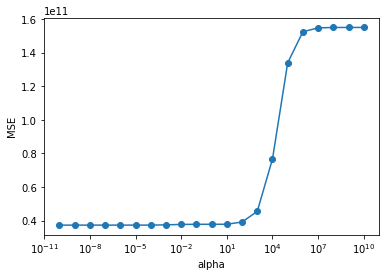

In [8]:
# Representemos el MSE para cada alpha
plt.semilogx(alphaVector,mseVector,'-o')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

A la vista de la figura, ¿con qué valor de $\alpha$ nos quedamos? A priori es difícil decirlo, quedémonos con los valores de $\alpha \leq 10^{3}$

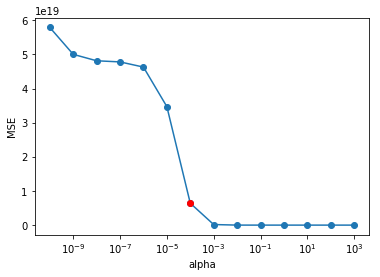

In [22]:
idx_alpha = alphaVector <= 1e3

plt.semilogx(alphaVector[idx_alpha],mseVector[idx_alpha],'-o')
plt.semilogx(alphaVector[alphaVector == 1e-4], mseVector[alphaVector == 1e-4],'ro')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

En función de la figura anterior, viendo la evolución del MSE, podríamos escoger cualquier valor de $\alpha$ comprendido en el intervalo $\alpha \in [10^{-10}, 10^{-4}]$ como valor óptimo para nuestro algoritmo.

Sin embargo, con esta metodología estamos haciendo un poco de **trampa** en el cálculo de $\alpha$, ¿por qué? Porque estamos utilizando el conjunto de test para ajustar los parámetros libres ($\alpha$) de mi algoritmo, y esto no es correcto, ya que el conjunto de test sólo lo utilizo cuando **TODOS** los parámetros del modelo han sido fijados y quiero evaluar sus prestaciones.

Necesitamos por tanto una nueva aproximación. Vamos a utilizar 10-fold cross-validation. 

# cross-validation

La validación cruzada (o cross-validation) consiste en subdivir el conjunto de entrenamiento en $K$ bloques, en K partes iguales, de tal forma que se utilizan $K-1$ para entrenar (ajustar el modelo) y el bloque $k$ restante para evaluar las prestaciones en función de los parámetros libres. Este proceso se repite $K$ veces (hasta que se barren todos los bloques) y los resultados se promedian.

Por suerte, no es necesario programar estas subdivisiones, porque scikit-learn tiene un clase que realiza este trabajo por nosotros. Puedes consultarlo [aquí](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [23]:
from sklearn.model_selection import KFold

number_of_folds = 10 #scikit-learn los llama splits
kf  = KFold(n_splits=number_of_folds, shuffle = True, random_state=1)

alphaVector = np.logspace(-4,4,21)

# inicializamos una matriz de errores, para cada valor de alpha y cada iteración del algoritmo de cross-validation
# - tantas filas como número de folds
# - tantas columnas como valores de alphaVector
mseMatriz = np.zeros((number_of_folds,len(alphaVector))) 


j = 0 # inicializamos contador de columnas
for alphaValue in alphaVector:
       
    ridgeModel = Ridge(alpha = alphaValue)
    
    i = 0 # inicializamos contador de filas
    for idxTrain, idxVal in kf.split(XtrainScaled):
      
        Xt = XtrainScaled[idxTrain,:]
        yt = ytrain[idxTrain]
        Xv = XtrainScaled[idxVal,:]
        yv = ytrain[idxVal]
        
        ridgeModel.fit(Xt,yt)
        ypred = ridgeModel.predict(Xv)   
        mseMatriz[i,j] = mean_squared_error(yv,ypred) 
        
        i+=1
    j+=1

mseVector = np.mean(mseMatriz,axis=0)

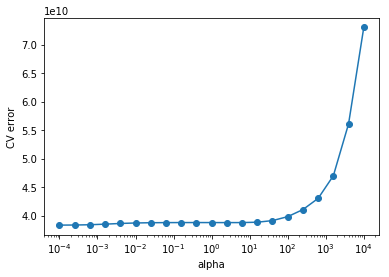

In [24]:
plt.semilogx(alphaVector,mseVector,'-o')
plt.xlabel('alpha')
plt.ylabel('CV error')
plt.show()

Vamos a buscar el valor de $\alpha$ que minimiza el error

In [25]:
idx = np.argmin(mseVector)
alphaOpt = alphaVector[idx]

print ('El valor óptimo de alpha es: %1.0g' % alphaOpt)

El valor óptimo de alpha es: 0.0001


Ahora ya estamos en disposición de evaluar las prestaciones del modelo 

In [13]:
ridgeModel = Ridge(alpha = alphaOpt)
ridgeModel.fit(XtrainScaled,ytrain)

ytrainRidge = ridgeModel.predict(XtrainScaled)
ytestRidge  = ridgeModel.predict(XtestScaled)
mseTrainModelRidge = mean_squared_error(ytrain,ytrainRidge)
mseTestModelRidge = mean_squared_error(ytest,ytestRidge)

print ('MSE Ridge (train): %0.3g' % mseTrainModelRidge)
print ('MSE Ridge (test) : %0.3g' % mseTestModelRidge)

MSE Ridge (train): 3.66e+10
MSE Ridge (test) : 3.73e+10


El error de test es pequeño (si lo comparamos con modelos definidos en Notebooks anteriores), por lo que a priori vamos por buen camino. 

Analicemos ahora el valor de los coeficientes del modelo $\boldsymbol{\omega}$, que al final es el resultado del algoritmo implementado:

In [14]:
counter=0
for f in feature_names:
    print(f,ridgeModel.coef_[0][counter])
    counter=counter+1

bedrooms 90296.64452947203
bathrooms -9802.20932496482
sqm_living 164251.416201956
sqm_lot 6984.32679151952
floors 9927.895106153876
waterfront 75127.70089845773
view 44407.56027126202
condition 15558.708073917418
grade 107661.39003784001
sqm_above 142053.47415997172
sqm_basement 77662.72289200516
yr_built -35091.17324373408
yr_renovated 10397.565555179977
zip_code -33366.825151315796
lat -18110609.342102934
long 7033678.4876142945
sqm_living15 30673.928915552922
sqm_lot15 -10665.300876275207
years 35091.15829430466
bedrooms_squared -143258.22851723523
bed_bath_rooms 83405.4192205151
log_sqm_living -213650.8249296473
lat_plus_long -20331746.016809847


<div class = "alert alert-success">
¿Concuerda el valor de los coeficientes con tu intuición sobre el problema? Fíjate por ejemplo en la variable *bedrooms*
</div>

El coeficiente asociado a la variable *bathrooms* es negativo, lo que quiere decir que al aumentar el valor de *bathrooms* disminuye el valor de *price*. Dicho de otra manera, este modelo nos dice que cuantas más habitaciones tenga una vivienda, menor será su valor.

Los modelo de machine learning buscan minimizar el error en las muestras de entrenamiento, y no en mejorar la interpretabilidad del modelo subyacente. Aquí reside el *arte* del data scientist, intentando diseñar variables que tengan capacidad predictiva y sean interpretables. 

Vamos a probar con otro modelo, Lasso, y comparemos los resultados con Ridge.

# Lasso

Se refiere al modelo de regresión lineal con penalización (norma 1) sobre la magnitud de los coeficientes

$$\min_{\boldsymbol{\omega}}|| \mathbf{y} - \mathbf{X}\boldsymbol{\omega}||_2^2 + \alpha ||\boldsymbol{\omega} ||_1$$

donde $||\boldsymbol{\omega} ||_1 = |\omega_1| + |\omega_2| + \ldots + |\omega_K|$, siendo $K$ el número de atributos ($\omega_0$ no se tiene en cuenta en esta penalización).

Con esta formulación el algoritmo Lasso permite activar/desactivar coeficientes, de tal forma que se desactivan primero los coeficienes asociados a los atributos que menos influyen en la función de coste (función a minimizar anterior). Con ello:

1. Se previene el overfitting, al poder utilizar modelos con menos variables (las desactivamos)
2. Se gana interpretabilidad, al poder ver cómo evolucionan las variables supervivientes.

La activación y desactivación de variables está determinada por el parámetro de regularización $\alpha$. Veamos algunos ejemplos:

In [26]:
from sklearn.linear_model import Lasso

# descomenta las línea de interés 
alphaValue = 1e-2    # un valor pequeño
#alphaValue = 1e3     # un valor medio
#alphaValue = 1e5     # un valor alto

lassoModel = Lasso(alpha = alphaValue)
lassoModel.fit(XtrainScaled,ytrain)

ytrainLasso = lassoModel.predict(XtrainScaled)
ytestLasso  = lassoModel.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(ytrain,ytrainLasso)
mseTestModelLasso = mean_squared_error(ytest,ytestLasso)

print ('MSE Ridge (train): %0.3g' % mseTrainModelLasso)
print( 'MSE Ridge (test) : %0.3g' % mseTestModelLasso)

counter=0
for f in feature_names:
    print(f,lassoModel.coef_[counter])
    counter=counter+1

MSE Ridge (train): 3.7e+10
MSE Ridge (test) : 3.78e+10
bedrooms 92775.35345305242
bathrooms -14658.193871855932
sqm_living 431077.99314351927
sqm_lot 8495.566179251868
floors 12461.04216626435
waterfront 73423.09927968257
view 45378.8964399026
condition 16590.69078713859
grade 108838.21180824723
sqm_above -96081.47306403177
sqm_basement -55676.47100531921
yr_built -74290.2493259179
yr_renovated 9577.015869387824
zip_code -28966.35986203159
lat 70822.07168674364
long -15015.18044545323
sqm_living15 27206.045994373984
sqm_lot15 -12477.341885369577
years -958.7050951600746
bedrooms_squared -150210.01095655936
bed_bath_rooms 91705.83544876875
log_sqm_living -211535.9795012748
lat_plus_long -12774.991341050938


C:\Users\junaj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Y, ¿cuál sería el valor de $\alpha$ óptimo? Sigamos una estrategia 10-fold CV, al igual que hicimos con el algoritmo ridge regression.

In [27]:
number_of_folds = 10 #scikit-learn los llama splits
kf  = KFold(n_splits=number_of_folds, shuffle = True, random_state=1)

alphaVector = np.logspace(-1,4,21)

# inicializamos una matriz de errores, para cada valor de alpha y cada iteración del algoritmo de cross-validation
# - tantas filas como número de folds
# - tantas columnas como valores de alphaVector
mseMatriz = np.zeros((number_of_folds,len(alphaVector))) 

j = 0 # inicializamos contador de columnas
for alphaValue in alphaVector:
       
    lassoModel = Lasso(alpha = alphaValue)
    
    i = 0 # inicializamos contador de filas
    for idxTrain, idxVal in kf.split(XtrainScaled):
      
        Xt = XtrainScaled[idxTrain,:]
        yt = ytrain[idxTrain]
        Xv = XtrainScaled[idxVal,:]
        yv = ytrain[idxVal]
        
        lassoModel.fit(Xt,yt)
        ypred = lassoModel.predict(Xv)   
        mseMatriz[i,j] = mean_squared_error(yv,ypred) 
        
        i+=1
    j+=1

mseVector = np.mean(mseMatriz,axis=0)

C:\Users\junaj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


El valor óptimo de alpha es: 3e+02


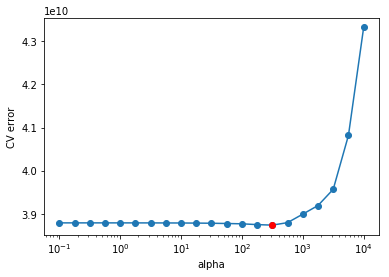

In [28]:
idx = np.argmin(mseVector)
alphaOpt = alphaVector[idx]
print ('El valor óptimo de alpha es: %1.0g' % alphaOpt)

plt.semilogx(alphaVector,mseVector,'-o')
plt.semilogx(alphaVector[idx],mseVector[idx],'ro')
plt.xlabel('alpha')
plt.ylabel('CV error')
plt.show()

In [29]:
lassoModel = Lasso(alpha = alphaOpt)
lassoModel.fit(XtrainScaled,ytrain)

ytrainLasso = lassoModel.predict(XtrainScaled)
ytestLasso  = lassoModel.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(ytrain,ytrainLasso)
mseTestModelLasso = mean_squared_error(ytest,ytestLasso)

print ('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print ('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)
counter=0
for f in feature_names:
    print(f,lassoModel.coef_[counter])
    counter=counter+1

MSE Modelo Lasso (train): 3.7e+10
MSE Modelo Lasso (test) : 3.78e+10
bedrooms 67119.3326584371
bathrooms 0.0
sqm_living 311320.8914320808
sqm_lot 7539.0303007025805
floors 10579.514996426662
waterfront 73420.04609136964
view 45080.282571613454
condition 16212.124923777623
grade 109012.04527770734
sqm_above 3524.2312096798046
sqm_basement 0.0
yr_built -53500.5711569502
yr_renovated 9041.416607365254
zip_code -28221.40141039441
lat 31805.923839329716
long -0.0
sqm_living15 27263.17810809217
sqm_lot15 -11636.216944213944
years 19648.082198695447
bedrooms_squared -115782.06113168983
bed_bath_rooms 70315.44139184855
log_sqm_living -202418.6821273437
lat_plus_long -55591.51805151941


Como puede apreciarse, con este algoritmo hemos conseguido "desactivar" algunas variables , lo que mejora la interpretabilidad del modelo a costa de aumentar ligeramente el error en test con respecto al método Ridge.

In [30]:
lassoModel = Lasso(alpha = 2e4)
lassoModel.fit(XtrainScaled,ytrain)

ytrainLasso = lassoModel.predict(XtrainScaled)
ytestLasso  = lassoModel.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(ytrain,ytrainLasso)
mseTestModelLasso = mean_squared_error(ytest,ytestLasso)

print ('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print ('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)
counter=0
for f in feature_names:
    print(f,lassoModel.coef_[counter])
    counter=counter+1

MSE Modelo Lasso (train): 4.44e+10
MSE Modelo Lasso (test) : 4.6e+10
bedrooms -0.0
bathrooms 0.0
sqm_living 145674.4945498313
sqm_lot 0.0
floors 0.0
waterfront 67361.71894785251
view 42754.95140929171
condition 0.0
grade 99372.26683107016
sqm_above 0.0
sqm_basement 0.0
yr_built -28593.257003496554
yr_renovated 0.0
zip_code -0.0
lat 33537.7034133022
long -0.0
sqm_living15 14674.648251922803
sqm_lot15 -0.0
years 9244.780687061118
bedrooms_squared -0.0
bed_bath_rooms 0.0
log_sqm_living 0.0
lat_plus_long -32890.564708566766


Hemos aumentado el error, pero a cambio:

1. Tenemos un modelo más sencillo (menos variables al haber muchos coeficientes nulos) y por tanto, menos susceptible a sufrir overfitting
2. Mejoramos la interpretabilidad del modelo, las variables supervivientes (con coeficiente distintos de cero) parecen concordar con nuestra intuición sobre problema a resolver